In [2]:
import os
import sys
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Compare baseline models

## Load global parameters

In [3]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [4]:
from pipelines.baseline_config import DATA_PATH, MAIN_PATH, DATASETS, SCALERS

In [5]:
# TODO: hack
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_scalers'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_bias_reg'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_bias_reg_insteps=2'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_diff_scalers'
MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_diff_bias_reg'

In [6]:
MODELS = ['mlp-diff', 'naive']  # baseline models
INPUT_TYPES = ['supervised', 'sequential']
PLOT_PATH = MAIN_PATH / "plots"
PLOT_PATH.mkdir(parents=True, exist_ok=True)
INPUT_FEATURES = 166

# Scalar heatmaps

## Load results

#### Based on name

In [6]:
# data = {}
# for model in MODELS:
#     for input_type in INPUT_TYPES:
#         for scaler in SCALERS:
#             for train_dataset in DATASETS:
#                 name = f"{model}_{input_type}_{scaler}_{train_dataset}"
#                 data[f"{name}_{train_dataset}"] = json.load(open(MAIN_PATH / name / 'scores' / f'{train_dataset}_train.json', 'r'))
#                 data[f"{name}_{train_dataset}_val"] = json.load(open(MAIN_PATH / name / 'scores' / f'{train_dataset}_val.json', 'r'))
#                 for dataset in DATASETS:
#                     if dataset != train_dataset:
#                         data[f"{name}_{dataset}"] = json.load(open(MAIN_PATH / name / 'scores' / f'{dataset}.json', 'r'))

#### Based on file content

In [7]:
data = {}
for path in (MAIN_PATH).iterdir():
    # ------ hack starts
    # 1) Select all data folders
    if path.name in ['plots', 'log', '.ipynb_checkpoints']:
        continue
    # 2) Scaler name may contain more than one word
    # Unfortunately, the same separator is used
    try:
        name = [path.name.replace(s, s.replace('_', '-')) for s in
                SCALERS if s in path.name][0]
    except:
        name = path.name
    # 3) Model name may contain more than one word
    elements = name.replace('mlp_diff', 'mlp-diff').split('_')
    # ------ hack ends
    (model, input_type, scaler, train_dataset), kwargs = elements[:4], "_".join(elements[5:])
    if kwargs:
        kwargs += '_'
    name = f"{model}_{input_type}_{scaler}_{kwargs}_{train_dataset}"
    # names.append(f"{model}_{input_type}_{scaler}".replace('-', '_'))
    data[f"{name}_{train_dataset}"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{train_dataset}_train.json', 'r'))
    data[f"{name}_{train_dataset}_val"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{train_dataset}_val.json', 'r'))
    for dataset in DATASETS:
        if dataset != train_dataset:
            data[f"{name}_{dataset}"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{dataset}.json', 'r'))

## Create arrays

In [8]:
arrays = {'Spearman mean': {},
          'Spearman std': {},
          'Spearman NaNs': {},
          'NRMSE mean': {},
          'NRMSE std': {},
          'NRMSE NaNs': {},
          'Bray-Curtis mean': {},
          'Bray-Curtis std': {},
          'Procrustis': {},
         }

# each measure computed as mean over bacteria
# Spearman number of predicted:
#   - TOTAL - zero response from model or expected is zero (one of two vectors is constant)
# NRMSE total - false positives:
#   - TOTAL - nonzero response when we expect zeros (false positive)

# for model in MODELS:
#     for input_type in INPUT_TYPES:
#         for scaler in SCALERS:
for name in set(k.split('__')[0] for k in data.keys()):
    # empty arrays
    tmp = dict(zip(arrays.keys(), [np.zeros([4,5]) for i in range(len(arrays))]))
    for i, d1 in enumerate(DATASETS):
        # validation
        datum = data[f"{name}__{d1}_{d1}_val"]
        tmp['Spearman mean'][i, 0] = datum['spearman'][0]
        tmp['Spearman std'][i, 0] = datum['spearman'][1]
        tmp['Spearman NaNs'][i, 0] = INPUT_FEATURES - datum['spearman'][2]
        tmp['NRMSE mean'][i, 0] = 1 / datum['nrmse'][0]
        tmp['NRMSE std'][i, 0] = 1 / datum['nrmse'][1]
        tmp['NRMSE NaNs'][i, 0] = INPUT_FEATURES - datum['nrmse'][2]
        tmp['Bray-Curtis mean'][i, 0] = 1 - datum['inter'][0]
        tmp['Bray-Curtis std'][i, 0] = 1 - datum['inter'][1]
        tmp['Procrustis'][i, 0] = 1 - datum['intra']
        # train / test
        for j, d2 in enumerate(DATASETS):
            datum = data[f"{name}__{d1}_{d2}"]
            tmp['Spearman mean'][i, j+1] = datum['spearman'][0]
            tmp['Spearman std'][i, j+1] = datum['spearman'][1]
            tmp['Spearman NaNs'][i, j+1] = INPUT_FEATURES - datum['spearman'][2]
            tmp['NRMSE mean'][i, j+1] = 1 / datum['nrmse'][0]
            tmp['NRMSE std'][i, j+1] = datum['nrmse'][1]
            tmp['NRMSE NaNs'][i, j+1] = INPUT_FEATURES - datum['nrmse'][2]
            tmp['Bray-Curtis mean'][i, j+1] = 1 - datum['inter'][0]
            tmp['Bray-Curtis std'][i, j+1] = datum['inter'][1]
            tmp['Procrustis'][i, j+1] = 1 - datum['intra']
    # array
    arrays['Spearman mean'][name] = tmp['Spearman mean'] 
    arrays['Spearman std'][name] = tmp['Spearman std'] 
    arrays['Spearman NaNs'][name] = tmp['Spearman NaNs'] 
    arrays['NRMSE mean'][name] = tmp['NRMSE mean'] 
    arrays['NRMSE std'][name] = tmp['NRMSE std'] 
    arrays['NRMSE NaNs'][name] = tmp['NRMSE NaNs'] 
    arrays['Bray-Curtis mean'][name] = tmp['Bray-Curtis mean'] 
    arrays['Bray-Curtis std'][name] = tmp['Bray-Curtis std'] 
    arrays['Procrustis'][name] = tmp['Procrustis'] 

In [9]:
kwargs = {'cmap': "YlGnBu", 'linewidth': 0.5,
          'xticklabels': ['validation', 'donorA', 'donorB', 'male', 'female'],
          'yticklabels': ['donorA', 'donorB', 'male', 'female'],
         }
plot_params = {'Spearman mean': {'label': 'Spearman coefficient', 'vmin': 0, 'vmax': 1},
               'NRMSE mean': {'label': '1 / NRMSE', 'vmin': 0, 'vmax': 'computed'},
               'Spearman NaNs': {'label': 'Spearman total - (false positives + false negatives)', 'vmin': 'computed', 'vmax': INPUT_FEATURES},
               'NRMSE NaNs': {'label': 'NRMSE total - false positives', 'vmin': 'computed', 'vmax': INPUT_FEATURES},
               'Bray-Curtis mean': {'label': 'Bray-Curtis similarity', 'vmin': 0, 'vmax': 1},
               'Procrustis': {'label': 'Procrustis similarity', 'vmin': 0, 'vmax': 1},
         }

### Example

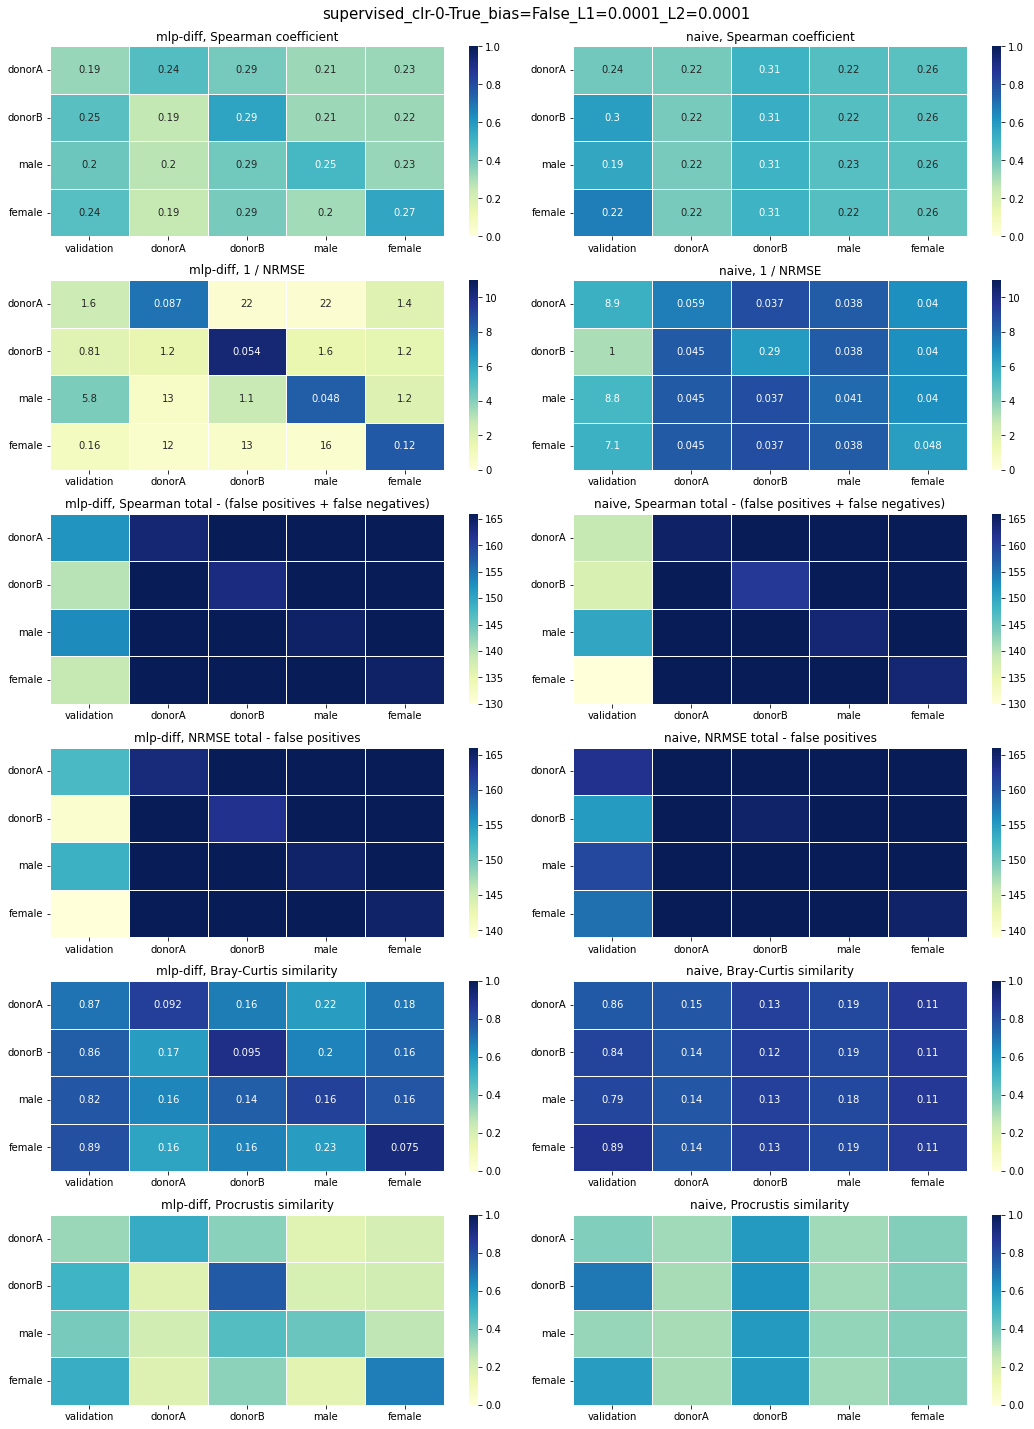

In [10]:
# name = "supervised_clr-0-True"
name = 'supervised_clr-0-True_bias=False_L1=0.0001_L2=0.0001'
plt.figure(figsize=(15,20))
for i, (k, v) in enumerate(plot_params.items()):
    plt.subplot(len(plot_params), 2, 2*i+1)
    # NRMSE mean / NaNs can be very different
    merged = np.concatenate([arrays[k][f'{MODELS[0]}_{name}'], arrays[k][f'{MODELS[1]}_{name}']])
    if v['vmax'] == 'computed':
        vmax = np.ceil(np.max(merged))
    else:
        vmax = v['vmax']
    # NRMSE NaNs can be very different
    if v['vmin'] == 'computed':
        vmin = np.min(merged)
    else:
        vmin = v['vmin']
    if 'mean' in k:
        annot_mlp = arrays[k.replace('mean', 'std')][f'{MODELS[0]}_{name}']
        annot_naive = arrays[k.replace('mean', 'std')][f'{MODELS[1]}_{name}']
    else:
        annot_mlp, annot_naive = None, None
    ax = sns.heatmap(arrays[k][f'{MODELS[0]}_{name}'], annot=annot_mlp, vmin=vmin, vmax=vmax, **kwargs)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(f'{MODELS[0]}, {v["label"]}')
    plt.subplot(len(plot_params), 2, 2*i+2)
    ax = sns.heatmap(arrays[k][f'{MODELS[1]}_{name}'], annot=annot_naive, vmin=vmin, vmax=vmax, **kwargs)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(f'{MODELS[1]}, {v["label"]}')
plt.suptitle(name, fontsize=15, y=0.99)
plt.tight_layout()
# plt.savefig(PLOT_PATH / f"{name}.png", dpi=200, facecolor='white')
plt.show()

### Loop

In [68]:
# for input_type in INPUT_TYPES:
#     for scaler in SCALERS:
#         name = f"{input_type}_{scaler}"
names = set("_".join(re.sub('(__).*', '', k).split('_')[1:]) for k in data.keys())
for count, name in enumerate(names):
    plt.figure(figsize=(15,20))
    for i, (k, v) in enumerate(plot_params.items()):
        plt.subplot(len(plot_params), 2, 2*i+1)
        # NRMSE mean / NaNs can be very different
        merged = np.concatenate([arrays[k][f'{MODELS[0]}_{name}'], arrays[k][f'{MODELS[1]}_{name}']])
        if v['vmax'] == 'computed':
            vmax = np.ceil(np.max(merged))
        else:
            vmax = v['vmax']
        # NRMSE NaNs can be very different
        if v['vmin'] == 'computed':
            vmin = np.min(merged)
        else:
            vmin = v['vmin']
        if 'mean' in k:
            annot_mlp = arrays[k.replace('mean', 'std')][f'{MODELS[0]}_{name}']
            annot_naive = arrays[k.replace('mean', 'std')][f'{MODELS[1]}_{name}']
        else:
            annot_mlp, annot_naive = None, None
        ax = sns.heatmap(arrays[k][f'{MODELS[0]}_{name}'], annot=annot_mlp, vmin=vmin, vmax=vmax, **kwargs)
        ax.tick_params(axis='y', rotation=0)
        ax.set_title(f'{MODELS[0]}, {v["label"]}')
        plt.subplot(len(plot_params), 2, 2*i+2)
        ax = sns.heatmap(arrays[k][f'{MODELS[1]}_{name}'], annot=annot_naive, vmin=vmin, vmax=vmax, **kwargs)
        ax.tick_params(axis='y', rotation=0)
        ax.set_title(f'{MODELS[1]}, {v["label"]}')
    plt.suptitle(name, fontsize=15, y=0.99)
    plt.tight_layout()
    plt.savefig(PLOT_PATH / f"{name}.png", dpi=200, facecolor='white')
    print(f"Done: {count+1} / {len(names)}", end='\r')
    plt.close()

# Vector plots

Analyse specific combinations deeper, looking at change in scores:
- over time (`f1_score`, `inter`) 
- over bacteria (`Spearman`, `NRMSE`)

In [49]:
# model
mname = 'mlp_diff'
intype = 'sequential'
scaler = 'clr_0_True'
trainset = 'male'
kwargs = 'use_input_bias=True_use_pred_bias=True_input_L1=0.001_input_L2=0.001_pred_L1=0_pred_L2=0'

# reference
ref_mname = 'naive'
ref_intype = 'supervised'
ref_scaler = 'clr_0_True'
ref_trainset = trainset  # TODO: fix in the future
ref_kwargs = 'use_bias=False_L1=0.0001_L2=0.0001'

score = 'nrmse'  # score we want to analyse
mname_full = f"{mname}_{intype}_{scaler}_{trainset}_{kwargs}"
ref_mname_full = f"{ref_mname}_{intype}_{scaler}_{trainset}_{kwargs}"
model_path = MAIN_PATH / mname_full / "scores"
ref_path = MAIN_PATH / ref_mname_full / "scores"
# NOTE: CHANGE IF SCORES HAVE CHANGED
xlabel = 'bacteria (index)' if score in ['nrmse', 'spearman'] else 'timestep (index)'

### Load data

In [50]:
data_vec = {}
data_ref_vec = {}
for d in DATASETS:
    if d == trainset:
        data_vec[f"{d}_train"] = pd.read_csv(model_path / f'{trainset}_train_{score}.csv', index_col=0)
        data_vec[f"{d}_val"] = pd.read_csv(model_path / f'{trainset}_val_{score}.csv', index_col=0)
    if d == ref_trainset:
        data_ref_vec[f"{d}_train"] = pd.read_csv(ref_path / f'{ref_trainset}_train_{score}.csv', index_col=0)
        data_ref_vec[f"{d}_val"] = pd.read_csv(ref_path / f'{ref_trainset}_val_{score}.csv', index_col=0)
    data_vec[d] = pd.read_csv(model_path / f'{d}_{score}.csv', index_col=0)
    data_ref_vec[d] = pd.read_csv(ref_path / f'{d}_{score}.csv', index_col=0)

In [51]:
assert data_vec.keys() == data_ref_vec.keys()

## Plots

### Matplotlib
Uncomment if you don't have `Plotly` installed (see below).

In [52]:
# plt.figure(figsize=(12, 4))
# ax = plt.subplot(1, 2, 1)
# # take difference wrt the reference
# tmp_t = data_vec[f"{trainset}_train"] -  data_ref_vec[f"{trainset}_train"]
# tmp_v = data_vec[f"{trainset}_val"] -  data_ref_vec[f"{trainset}_val"]
# ax.plot(range(1, 1+len(tmp_t)), tmp_t, label=f"train: {tmp_t.mean()[0]:.2f}")
# ax.plot(range(1, 1+len(tmp_v)), tmp_v, label=f"valid: {tmp_v.mean()[0]:.2f}")
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
# ax.set(title=f"{score}, train/val", xlabel=xlabel, ylabel='model - reference')
# ax.legend()
# ax = plt.subplot(1, 2, 2)
# for d in DATASETS:
#     # take difference wrt the reference
#     tmp_test = data_vec[d] - data_ref_vec[d]
#     ax.plot(range(1, 1+len(tmp_test)), tmp_test, label=f"{d}: {tmp_test.mean()[0]:.2f}")
# ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
# ax.set(title=f"{score}, test", xlabel=xlabel, ylabel='model - reference')
# ax.legend()
# plt.suptitle(f"Model: {mname_full}\nReference: {ref_mname_full}")
# plt.tight_layout()
# plt.show()

### Plotly
Doc: https://plotly.com/python/subplots/

In [53]:
import plotly
import plotly.graph_objects as go

from IPython.display import IFrame
from plotly.subplots import make_subplots

In [54]:
fig = make_subplots(rows=1, cols=2, x_title=xlabel, y_title='model - reference',
                    subplot_titles=[f"{score}, train/val", f"{score}, test"])
# train / val
# take difference wrt the reference (naive)
tmp_t = data_vec[f"{trainset}_train"] -  data_ref_vec[f"{trainset}_train"]
tmp_v = data_vec[f"{trainset}_val"] -  data_ref_vec[f"{trainset}_val"]
fig.add_trace(go.Scatter(y=tmp_t.values[:,0], name=f"train: {tmp_t.mean()[0]:.2f}"), row=1, col=1)
fig.add_trace(go.Scatter(y=tmp_v.values[:,0], name=f"val: {tmp_v.mean()[0]:.2f}"), row=1, col=1)
# test
# take difference wrt the reference (naive)
for d in DATASETS:
    # take difference wrt the reference (naive)
    tmp_test = data_vec[d] - data_ref_vec[d]
    fig.add_trace(go.Scatter(x=list(range(1, 1+len(tmp_test))), y=tmp_test.values[:,0], 
                             name=f"{d}: {tmp_test.mean()[0]:.2f}"), row=1, col=2)
fig.update_layout(showlegend=True, font=dict(size=8),
                  title_text=f"<b>Model:</b> {mname_full}<br><b>Reference:</b> {ref_mname_full}")
plotly.offline.plot(fig, filename = f"{PLOT_PATH}/vector_{score}_{mname_full}.html", auto_open=False)
IFrame(src=f"{os.path.relpath(PLOT_PATH)}/vector_{score}_{mname_full}.html", width=1000, height=400)

# Predictions

See raw predictions for specifc model and bacteria

**Note:** timesteps order may be random!

### Load data

In [55]:
train_pred = np.load(model_path.parents[0] /  f'train_val_predictions.npz')
test_pred = np.load(model_path.parents[0] /  f'test_predictions.npz')
train_pred_ref = np.load(ref_path.parents[0] /  f'train_val_predictions.npz')
test_pred_ref = np.load(ref_path.parents[0] /  f'test_predictions.npz')

In [56]:
# Should agree if testing datasets weren't shuffled before prediction
for d in DATASETS:
    assert (test_pred[f'{d}_test_inv_y'] == test_pred_ref[f'{d}_test_inv_y']).all()

In [57]:
bact = 53  # bacterium index

## Plots

### Matplotlib

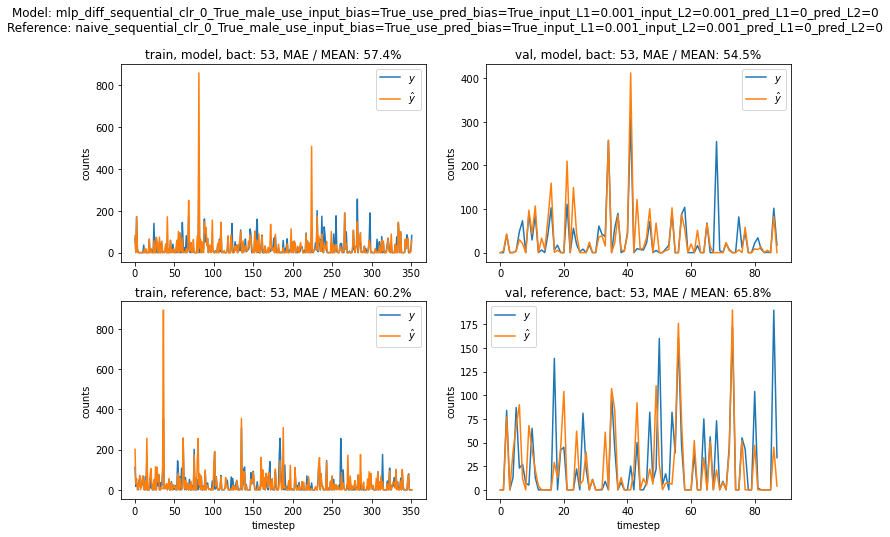

In [58]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['train', 'val']):
    ax = plt.subplot(2, 2, i+1)
    y = train_pred[f'{label}_inv_y'][:, bact]
    yhat = train_pred[f'{label}_inv_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / y.mean() * 100
    # error2 = abs((y-yhat) / y * 100).mean()  # may explode if y = 0
    ax.plot(y, label=r'$y$')
    ax.plot(yhat, label=r'$\hat{y}$')
    ax.set(title=f'{label}, model, bact: {bact}, MAE / MEAN: {error:.1f}%', ylabel='counts')
    ax.legend()
for i, label in enumerate(['train', 'val']):
    ax = plt.subplot(2, 2, i+3)
    y = train_pred_ref[f'{label}_inv_y'][:, bact]
    yhat = train_pred_ref[f'{label}_inv_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / y.mean() * 100
    # error2 = abs((y-yhat) / y * 100).mean()  # may explode if y = 0
    ax.plot(y, label=r'$y$')
    ax.plot(yhat, label=r'$\hat{y}$')
    ax.set(title=f'{label}, reference, bact: {bact}, MAE / MEAN: {error:.1f}%', 
           xlabel='timestep', ylabel='counts')
    ax.legend()
plt.suptitle(f"Model: {mname_full}\nReference: {ref_mname_full}")
plt.show()

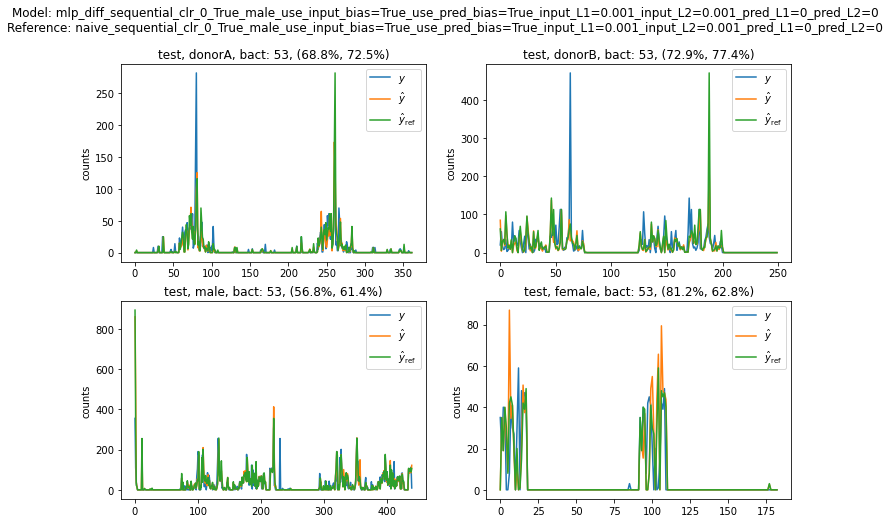

In [59]:
plt.figure(figsize=(12, 8))
for i, d in enumerate(DATASETS):
    ax = plt.subplot(2, 2, i+1)
    y = test_pred[f'{d}_test_inv_y'][:, bact]
    yhat = test_pred[f'{d}_test_inv_yhat'][:, bact]
    yhat_ref = test_pred_ref[f'{d}_test_inv_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / y.mean() * 100
    error_ref = sum(abs(y - yhat_ref)) / len(y) / y.mean() * 100
    ax.plot(y, label=r'$y$')
    ax.plot(yhat, label=r'$\hat{y}$')
    ax.plot(yhat_ref, label=r'$\hat{y}_{\rm ref}$')
    ax.set(title=f'test, {d}, bact: {bact}, ({error:.1f}%, {error_ref:.1f}%)', ylabel='counts')
    ax.legend()
plt.suptitle(f"Model: {mname_full}\nReference: {ref_mname_full}")
plt.show()

### Plotly
Doc: https://plotly.com/python/subplots/

In [60]:
fig = make_subplots(rows=2, cols=2, x_title='timestep', y_title='counts',
                    subplot_titles=[f"train, model, bact: {bact}",
                                    f"val, model, bact: {bact}",
                                    f"train, reference, bact: {bact}",
                                    f"val, reference, bact: {bact}"])
# train/val, model
for i, label in enumerate(['train', 'val']):
    y = train_pred[f'{label}_inv_y'][:, bact]
    yhat = train_pred[f'{label}_inv_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / y.mean() * 100
    fig.add_trace(go.Scatter(y=y, name=f"y"), row=1, col=i+1)
    fig.add_trace(go.Scatter(y=yhat, name=f"yhat, {error:.1f}%"), row=1, col=i+1)
# train/val, reference
for i, label in enumerate(['train', 'val']):
    y = train_pred_ref[f'{label}_inv_y'][:, bact]
    yhat = train_pred_ref[f'{label}_inv_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / y.mean() * 100
    fig.add_trace(go.Scatter(y=y, name=f"y"), row=2, col=i+1)
    fig.add_trace(go.Scatter(y=yhat, name=f"yhat, {error:.1f}%"), row=2, col=i+1)
fig.update_layout(showlegend=True, font=dict(size=8),
                  title_text=f"<b>Model:</b> {mname_full}<br><b>Reference:</b> {ref_mname_full}")
plotly.offline.plot(fig, filename = f"{PLOT_PATH}/pred_train_{bact}_{mname_full}.html", auto_open=False)
IFrame(src=f"{os.path.relpath(PLOT_PATH)}/pred_train_{bact}_{mname_full}.html", width=1000, height=500)

In [61]:
fig = make_subplots(rows=2, cols=2, x_title='timestep', y_title='counts',
                    subplot_titles=[f"test, {d}, bact: {bact}" for d in DATASETS])
# test
for i, d in enumerate(DATASETS):
    row=i//2+1; col=i%2+1
    y = test_pred[f'{d}_test_inv_y'][:, bact]
    yhat = test_pred[f'{d}_test_inv_yhat'][:, bact]
    yhat_ref = test_pred_ref[f'{d}_test_inv_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / y.mean() * 100
    error_ref = sum(abs(y - yhat_ref)) / len(y) / y.mean() * 100
    fig.add_trace(go.Scatter(y=y, name=f"y"), row=row, col=col)
    fig.add_trace(go.Scatter(y=yhat, name=f"yhat, {error:.1f}%"), row=row, col=col)
    fig.add_trace(go.Scatter(y=yhat_ref, name=f"yhat_ref, {error_ref:.1f}%"), row=row, col=col)
fig.update_layout(showlegend=True, font=dict(size=8),
                  title_text=f"<b>Model:</b> {mname_full}<br><b>Reference:</b> {ref_mname_full}")
plotly.offline.plot(fig, filename = f"{PLOT_PATH}/pred_test_{bact}_{mname_full}.html", auto_open=False)
IFrame(src=f"{os.path.relpath(PLOT_PATH)}/pred_test_{bact}_{mname_full}.html", width=1000, height=500)